In [1]:
import collections
import math
import matplotlib.pyplot as plt
import os
import os.path
import random
from sklearn.manifold import TSNE
from six.moves import urllib
import tensorflow as tf
import zipfile

%matplotlib inline

In [2]:
sess = tf.InteractiveSession()

In [3]:
# Download the data file.
def verify_file_size(filename, expected_bytes):
    statinfo = os.stat(filename)
    return statinfo.st_size == expected_bytes


def download_and_verify_mattmahoney(filename, expected_bytes):
    url = "http://mattmahoney.net/dc/"
    filename, _ = urllib.request.urlretrieve(url + filename, filename)
    if verify_file_size(filename, expected_bytes):
        print "Downloaded and verified", filename
    else:
        raise Exception("Failed to download and verify " + filename)
        

def download_data():
    filename = "text8.zip"
    expected_bytes = 31344016
    if os.path.exists(filename) and verify_file_size(filename, expected_bytes):
        print "File exists and is verified for size"
    else:
        download_and_verify_mattmahoney(filename, expected_bytes)
    return filename
        
        
data_file = download_data()

File exists and is verified for size


In [4]:
# Read the data into a list of strings.
def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        file_content = f.read(f.namelist()[0])
    return file_content.split()


words = read_data(data_file)
print "Data size:", len(words), "words"
print "First 100 words:", " ".join(words[:100])

Data size: 17005207 words
First 100 words: anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing


In [5]:
# Build the dictionary and replace rare words with UNK token.
def build_dataset(words, vocabulary_size):
    """Create a data set for further processing.
    
    Returns
    -------
        data: list of same length as "words", but replace string with index
        count: list of (index, num) tuples, sorted by `num` except for the first item, which is `UNK`
        dictionary: map from word to index
        reverse_dictionary: map from index back to word
    """
    count = [["UNK", -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size-1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary


vocabulary_size = 50000
data, count, dictionary, reverse_dictionary = build_dataset(words, vocabulary_size)
del words  # Reduce memory usage
print "Most common words (+UNK)", count[:10]
print "First 20 index / words:", data[:20], [reverse_dictionary[i] for i in data[:20]]

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430)]
First 20 index / words: [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156, 128, 742, 477, 10572, 134, 1, 27549, 2, 1, 103] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english']


In [6]:
# Generate a training batch for the skip-gram model.
def generate_batch(data, batch_size, num_skips, skip_window, data_index):
    """Generate a batch of training data.
    
    Parameters
    ----------
        data: the data vector
        batch_size: the size of output batch
        num_skips: number of times to re-use a skip window
        skip_window: number of words to consider left and right
        data_index: the index on where to generate next batch
    """
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape = batch_size, dtype = np.int32)
    labels = np.ndarray(shape = (batch_size, 1), dtype = np.int32)
    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen = span)
    for _ in xrange(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in xrange(batch_size // num_skips):
        target = skip_window
        targets_to_avoid = [skip_window]
        for j in xrange(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span-1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j,0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels, data_index


batch_size = 8
num_skips = 2
skip_window = 1
data_index = 0
batch, labels, data_index = generate_batch(data, batch_size, num_skips, skip_window, data_index)
for i in xrange(batch_size):
    print (batch[i], reverse_dictionary[batch[i]]), "->", (labels[i,0], reverse_dictionary[labels[i,0]])

(3084, 'originated') -> (5239, 'anarchism')
(3084, 'originated') -> (12, 'as')
(12, 'as') -> (6, 'a')
(12, 'as') -> (3084, 'originated')
(6, 'a') -> (12, 'as')
(6, 'a') -> (195, 'term')
(195, 'term') -> (2, 'of')
(195, 'term') -> (6, 'a')


In [7]:
# Build and train a skip-gram model.
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector
skip_window = 1
num_skips = 2

valid_size = 16       # Random set of words to evaluate.
valid_window = 100    # Only pick validation samples in head of the distribution
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64      # Number of negative examples to sample

# Input data.
train_inputs = tf.placeholder(tf.int32, shape = [batch_size])
train_labels = tf.placeholder(tf.int32, shape = [batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype = tf.int32)

# Embedding.
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

# NCE loss.
nce_weights = tf.Variable(tf.truncated_normal(
        [vocabulary_size, embedding_size],
        stddev = 1.0 / math.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_biases, embed, train_labels, num_sampled, vocabulary_size))

# Optimizer.
optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

# Cos similarity.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims = True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b = True)

# Variable initializers.
init = tf.initialize_all_variables()

In [8]:
# Train the model.
num_steps = 100001
sess.run(init)

data_index = 0
average_loss = 0
for step in xrange(num_steps):
    batch_inputs, batch_labels, data_index = generate_batch(data, batch_size, num_skips, skip_window, data_index)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
    
    _, loss_val = sess.run([optimizer, loss], feed_dict = feed_dict)
    average_loss += loss_val
    
    if step % 2000 == 0:
        if step > 0:
            average_loss /= 2000
        print "Average loss at step", step, ":", average_loss
        average_loss = 0
    
    if step % 10000 == 0:
        sim = similarity.eval()
        for i in xrange(valid_size):
            valid_word = reverse_dictionary[valid_examples[i]]
            top_k = 8
            nearest = (-sim[i, :]).argsort()[1:top_k+1]
            log_str = "Nearest to %s:" % valid_word
            for k in xrange(top_k):
                close_word = reverse_dictionary[nearest[k]]
                log_str = "%s %s," % (log_str, close_word)
            print log_str


final_embeddings = normalized_embeddings.eval()

Average loss at step 0 : 280.83581543
Nearest to who: pull, becomes, tablet, astor, partitioned, cactus, flowing, cancellation,
Nearest to his: nan, postpositions, caudal, granny, billboard, labia, woodpeckers, fock,
Nearest to by: dualistic, phlogiston, azul, rockne, avail, martyred, mugwort, uwe,
Nearest to UNK: effendi, queues, fiefdom, scriptwriter, corpora, disparate, containers, ideation,
Nearest to not: induces, freefall, knot, smyrnaeans, sahel, iain, bourbaki, levy,
Nearest to nine: hobby, harcourt, directional, noon, condominiums, surprising, vertov, sacrificed,
Nearest to most: axiomatization, southerner, turnaround, brenda, beards, aloha, salian, statutory,
Nearest to called: syllabics, homesick, coercion, steak, imaging, canaanites, aggadah, clearinghouse,
Nearest to the: graze, metrolink, researching, cheka, annapolis, monitor, fifties, youssef,
Nearest to and: shadowed, scorers, differing, dials, collectivization, receive, lindsey, desmo,
Nearest to between: crazed, hang

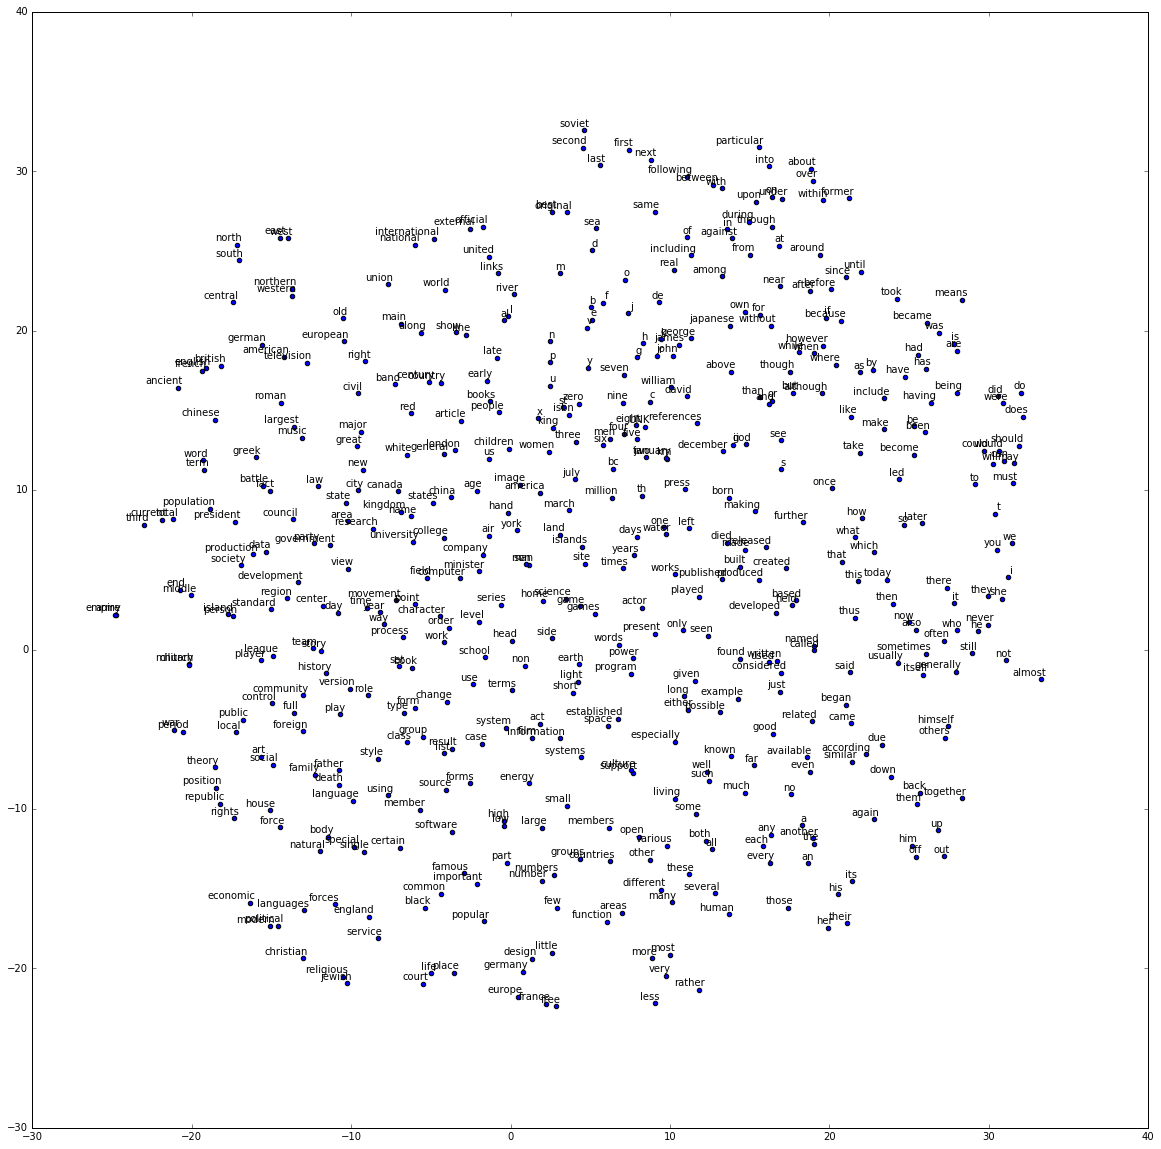

In [9]:
# Visualize the embeddings
def plot_with_labels(low_dim_embeds, labels):
    assert low_dim_embeds.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize = (20, 20))
    for i, label in enumerate(labels):
        x, y = low_dim_embeds[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                    xy = (x, y),
                    xytext = (5, 2),
                    textcoords = "offset points",
                    ha = "right",
                    va = "bottom")


tsne = TSNE(perplexity = 30, n_components = 2, init = "pca", n_iter = 5000)
plot_only = 500
low_dim_embeds = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in xrange(plot_only)]
plot_with_labels(low_dim_embeds, labels)